
# 📈 Crypto Price Trend (t+1)

**Mục tiêu:** Dự đoán *xu hướng giá* tại thời điểm **t+1** (tăng hoặc giảm) dựa trên thông tin ở **t**.  
**Loại bài toán:** *Binary Classification* — `trend_t+1 ∈ {0,1}` với `1 = tăng`, `0 = giảm/không tăng`.



In [4]:

# === Setup ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve)

RANDOM_STATE = 42
pd.set_option("display.max_columns", 100)


## 1) Đọc dữ liệu & kiểm tra nhanh

In [5]:

PATH = "processed_cryptotocurrency.csv"
df = pd.read_csv(PATH)

df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(["symbol", "timestamp"]).reset_index(drop=True)

print("Kích thước:", df.shape, "| Số symbol:", df["symbol"].nunique())
print("Số mốc thời gian:", df["timestamp"].nunique())
display(df.head(3))
print("Thiếu giá trị tổng:", df.isna().sum().sum())


Kích thước: (170430, 10) | Số symbol: 287
Số mốc thời gian: 6318


,timestamp,name,symbol,price_usd,vol_24h,total_vol,chg_24h,chg_7d,market_cap,name_encoded
0,2025-04-10 10:36:00,0G,0g,3.07,328906282.0,0.0010,0.0277,-0.1897,656448544.0,0
1,2025-04-10 10:39:00,0G,0g,3.07,326561005.0,0.0009,0.0200,-0.1919,653965794.0,0
2,2025-04-10 10:52:00,0G,0g,3.05,219867828.0,0.0006,0.0030,-0.1963,650369931.0,0


Thiếu giá trị tổng: 0


## 2) Tạo nhãn (label) xu hướng & đặc trưng trễ/rolling

In [6]:

def add_features(_g: pd.DataFrame) -> pd.DataFrame:
    g = _g.sort_values("timestamp").copy()
    g["price_t-1"] = g["price_usd"].shift(1)
    g["ma_3"] = g["price_usd"].rolling(3).mean()
    g["ma_7"] = g["price_usd"].rolling(7).mean()
    g["price_t+1"] = g["price_usd"].shift(-1)
    g["trend_t+1"] = (g["price_t+1"] > g["price_usd"]).astype(int)
    return g

df_feat = df.groupby("symbol", group_keys=False).apply(add_features)

feature_cols = ["price_t-1", "ma_3", "ma_7", "chg_24h", "chg_7d", "vol_24h", "market_cap"]
label_col = "trend_t+1"

df_model = df_feat.dropna(subset=feature_cols + ["price_usd", "price_t+1", label_col]).reset_index(drop=True)

print("Kích thước df_model:", df_model.shape)
display(df_model[["timestamp","symbol","price_usd","price_t-1","ma_3","ma_7","price_t+1","trend_t+1"]].head(10))


Kích thước df_model: (168722, 15)


/tmp/ipython-input-3537374460.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df.groupby("symbol", group_keys=False).apply(add_features)


,timestamp,symbol,price_usd,price_t-1,ma_3,ma_7,price_t+1,trend_t+1
0,2025-01-04 07:34:00,ADA,0.6687,0.6704,0.668367,0.663900,0.6738,1
1,2025-01-04 08:34:00,ADA,0.6738,0.6687,0.670967,0.665843,0.6726,0
2,2025-01-04 09:34:00,ADA,0.6726,0.6738,0.671700,0.668229,0.6709,0
3,2025-01-04 10:34:00,ADA,0.6709,0.6726,0.672433,0.669700,0.6754,1
4,2025-01-04 11:34:00,ADA,0.6754,0.6709,0.672967,0.671114,0.6814,1
5,2025-01-04 12:34:00,ADA,0.6814,0.6754,0.675900,0.673314,0.6811,0
6,2025-01-04 13:34:00,ADA,0.6811,0.6814,0.679300,0.674843,0.6755,0
7,2025-01-04 14:34:00,ADA,0.6755,0.6811,0.679333,0.675814,0.6767,1
8,2025-01-04 15:34:00,ADA,0.6767,0.6755,0.677767,0.676229,0.6737,0
9,2025-01-04 16:34:00,ADA,0.6737,0.6767,0.675300,0.676386,0.6707,0


## 3) Chia dữ liệu theo thời gian (time-based split)

In [7]:

X = df_model[feature_cols]
y = df_model[label_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Tỉ lệ lớp train:", y_train.mean().round(4), "— test:", y_test.mean().round(4))


Train: (134977, 7) | Test: (33745, 7)
Tỉ lệ lớp train: 0.4136 — test: 0.2763


## 4) Baseline

In [8]:

# Dự đoán tăng nếu price_t > price_{t-1} (so với trạng thái hiện tại)
y_pred_naive = (X_test["price_t-1"].values < df_model.loc[X_test.index, "price_usd"].values).astype(int)

def report_cls(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{name}: ACC={acc:.4f} | PREC={prec:.4f} | REC={rec:.4f} | F1={f1:.4f}")
    return acc, prec, rec, f1

_ = report_cls(y_test, y_pred_naive, "Naive (price_t vs price_{t-1})")


Naive (price_t vs price_{t-1}): ACC=0.6914 | PREC=0.4415 | REC=0.4413 | F1=0.4414


## 5) Huấn luyện mô hình: RandomForest & XGBoost

In [9]:

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
xgb = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.9,
                    colsample_bytree=0.9, random_state=42, n_jobs=-1, objective="binary:logistic",
                    eval_metric="logloss")

rf.fit(X_train, y_train); xgb.fit(X_train, y_train)

y_pred_rf,  y_proba_rf  = rf.predict(X_test),  rf.predict_proba(X_test)[:,1]
y_pred_xgb, y_proba_xgb = xgb.predict(X_test), xgb.predict_proba(X_test)[:,1]

report_cls(y_test, y_pred_rf,  "RandomForest")
report_cls(y_test, y_pred_xgb, "XGBoost")


RandomForest: ACC=0.6379 | PREC=0.3663 | REC=0.4256 | F1=0.3937
XGBoost: ACC=0.6589 | PREC=0.3766 | REC=0.3585 | F1=0.3673


(0.6588531634316195,
 0.37664825876253805,
 0.358468304193929,
 0.36733347988568915)

## 6) ROC/AUC & Confusion Matrix

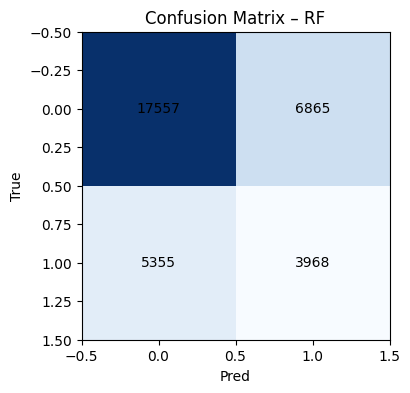

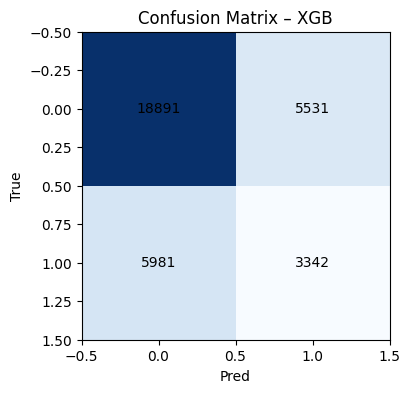

AUC RF=0.6667 | AUC XGB=0.6818


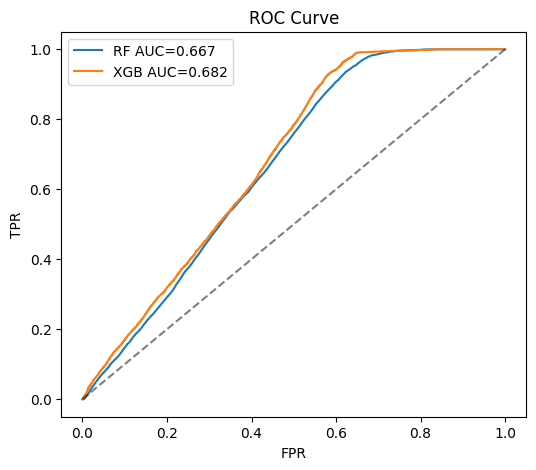

In [10]:

def plot_cm(cm, title):
    import numpy as np
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(cm, cmap="Blues")
    ax.set_title(title); ax.set_xlabel("Pred"); ax.set_ylabel("True")
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, v, ha="center", va="center")
    plt.show()

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
cm_rf  = confusion_matrix(y_test, y_pred_rf)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plot_cm(cm_rf, "Confusion Matrix – RF")
plot_cm(cm_xgb, "Confusion Matrix – XGB")

auc_rf  = roc_auc_score(y_test, y_proba_rf)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"AUC RF={auc_rf:.4f} | AUC XGB={auc_xgb:.4f}")

fpr_rf, tpr_rf, _   = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f"RF AUC={auc_rf:.3f}")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB AUC={auc_xgb:.3f}")
plt.plot([0,1],[0,1],"k--", alpha=.5)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.title("ROC Curve"); plt.show()


## 7) Feature Importance (RF)

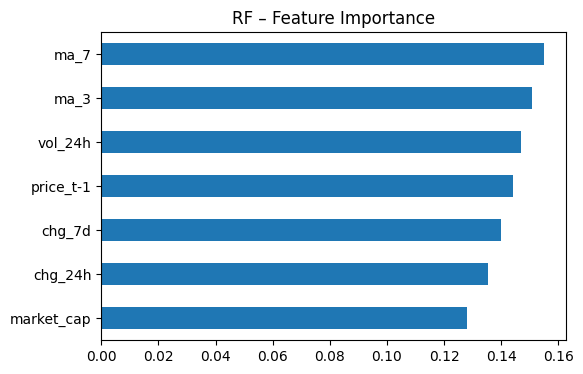

,importance
ma_7,0.155038
ma_3,0.150659
vol_24h,0.146924
price_t-1,0.143979
chg_7d,0.140032
chg_24h,0.135340
market_cap,0.128028


In [11]:

imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
ax = imp.plot(kind="barh", figsize=(6,4)); ax.invert_yaxis(); ax.set_title("RF – Feature Importance")
plt.show(); display(imp.to_frame("importance"))


## 8) Độ chính xác theo từng symbol

In [12]:

viz = df_model.loc[X_test.index, ["symbol"]].copy()
viz["y_true"] = y_test.values; viz["y_pred_rf"] = y_pred_rf
acc_by_symbol = viz.groupby("symbol").apply(lambda g: accuracy_score(g["y_true"], g["y_pred_rf"])).sort_values(ascending=False)
print("Top-10 symbol (ACC):"); display(acc_by_symbol.head(10).to_frame("ACC"))
print("Bottom-10 symbol (ACC):"); display(acc_by_symbol.tail(10).to_frame("ACC"))


Top-10 symbol (ACC):


/tmp/ipython-input-1236971802.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_symbol = viz.groupby("symbol").apply(lambda g: accuracy_score(g["y_true"], g["y_pred_rf"])).sort_values(ascending=False)


,ACC
symbol,
usdc,1.000000
usdf,1.000000
susde,0.999296
usds,0.998593
usdt0,0.998593
usde,0.990148
susds,0.949227
wlfi,0.874032
usdt,0.839523


Bottom-10 symbol (ACC):


,ACC
symbol,
steth,0.505982
wsteth,0.503167
zec,0.499544
xrp,0.494018
sol,0.491525
uni,0.485574
sui,0.475721
wbt,0.470091
ton,0.338256


## 9) TimeSeriesSplit Cross‑Validation (ACC)

In [ ]:

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
                         df_model[feature_cols], df_model[label_col], cv=tscv, scoring="accuracy", n_jobs=-1)
print("RF – TimeSeriesSplit ACC:", scores.round(4), " | mean:", scores.mean().round(4))
